In [ ]:
import pandas as pd
import numpy as np
import os

# image manipulation libraries
from skimage.io import imread
from skimage.transform import resize
from PIL import Image
from keras.preprocessing.image import img_to_array

# machine learning libraries
from sklearn.model_selection import train_test_split
import keras
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, PReLU
from keras.models import load_model

# model and image visualization libraries
import matplotlib.pyplot as plt

In [ ]:
# preload path names for ease of use
path = "drive/MyDrive/GalaxyClassification"
image_path = "drive/MyDrive/GalaxyClassification/training_images"
processed_data_path = "drive/MyDrive/GalaxyClassification/processed_data.csv"

In [ ]:
# this is the csv file containing the table from the original dataset
solutions = pd.read_csv("drive/MyDrive/GalaxyClassification/training_solutions_rev1.csv")
solutions

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,Class5.2,Class5.3,Class5.4,Class6.1,Class6.2,Class7.1,Class7.2,Class7.3,Class8.1,Class8.2,Class8.3,Class8.4,Class8.5,Class8.6,Class8.7,Class9.1,Class9.2,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,0.000000,0.104752,0.512101,0.000000,0.054453,0.945547,0.201463,0.181684,0.000000,0.00000,0.027226,0.000000,0.027226,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.000000,0.000000,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,0.000000,0.236781,0.160941,0.234877,0.189149,0.810851,0.000000,0.135082,0.191919,0.00000,0.000000,0.140353,0.000000,0.048796,0.000000,0.000000,0.012414,0.0,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.000000,0.000000,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,0.000000,0.117790,0.059562,0.000000,0.000000,1.000000,0.000000,0.741864,0.023853,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,0.000000,0.000000,0.113284,0.125280,0.320398,0.679602,0.408599,0.284778,0.000000,0.00000,0.000000,0.096119,0.096119,0.000000,0.128159,0.000000,0.000000,0.0,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.000000,0.000000,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029383,0.970617,0.494587,0.439252,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.029383,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61573,999948,0.510379,0.489621,0.000000,0.059207,0.430414,0.000000,0.430414,0.226257,0.204157,0.043458,0.260804,0.000000,0.126152,0.245734,0.754266,0.000000,0.410816,0.099563,0.03514,0.000000,0.000000,0.000000,0.175454,0.035140,0.000000,0.059207,0.0,0.000000,0.226257,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.226257
61574,999950,0.901216,0.098784,0.000000,0.000000,0.098784,0.000000,0.098784,0.000000,0.098784,0.000000,0.045378,0.053406,0.000000,0.127644,0.872356,0.404841,0.496375,0.000000,0.00000,0.000000,0.021321,0.000000,0.062095,0.044229,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
61575,999958,0.202841,0.777376,0.019783,0.116962,0.660414,0.067245,0.593168,0.140022,0.520391,0.000000,0.257128,0.347328,0.055958,0.839186,0.160814,0.030477,0.172364,0.000000,0.00000,0.000000,0.033567,0.134270,0.067135,0.604214,0.000000,0.116962,0.0,0.000000,0.000000,0.090673,0.049349,0.000000,0.067726,0.000000,0.000000,0.0,0.072296
61576,999964,0.091000,0.909000,0.000000,0.045450,0.863550,0.022452,0.841098,0.795330,0.068220,0.000000,0.227114,0.545764,0.090673,0.864000,0.136000,0.045500,0.045500,0.000000,0.09072,0.000000,0.090720,0.136512,0.045792,0.500256,0.000000,0.045450,0.0,0.000000,0.068398,0.318132,0.408799,0.227464,0.408799,0.090668,0.023065,0.0,0.045334


The Classes with the same A value (format Class A.B) sum to 1, each B value is the percent of users that identified the galaxy as having the identified feature.

* Class 1.1: smooth and rounded
* Class 1.2: features or disk
* Class 1.3: star or artifact
* 
* Class 2.1: disk viewed edge-on
* Class 2.2: no
* 
* Class 3.1: bar feature
* Class 3.2: no
*
* Class 4.1: spiral arms
* Class 4.2: no
*
* Class 5.1: no bulge
* Class 5.2: just noticeable bulge
* Class 5.3: obvious bulge
* Class 5.4: dominant bulge
*
* Class 6.1: something odd (possible feature)
* Class 6.2: no
* 
* Class 7.1: completely round
* Class 7.2: in between
* Class 7.3: cigar shaped
*
* Class 8.1: ring
* Class 8.2: lens or arc
* Class 8.3: disturbed
* Class 8.4: irregular
* Class 8.5: other
* Class 8.6: merger
* Class 8.7: dust lane
* 
* Class 9.1: rounded bulge
* Class 9.2: boxy bulge
* Class 9.3: no bulge
*
* Class 10.1: tightly wound spiral arms
* Class 10.2: medium windedness
* Class 10.3: loosely wound spiral arms
*
* Class 11.1: 1 arm
* Class 11.2: 2 arms
* Class 11.3: 3 arms
* Class 11.4: 4 arms
* Class 11.5: 5+ arms
* Class 11.6: Can't tell arm number


# Test Image Data and Methods

In this section, I am examining the original images to find the right deminsions to crop them to so that, even in an image with other galaxies, the model can focus on the central galaxy.

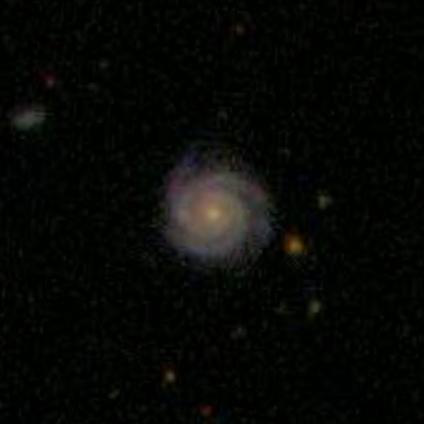

In [ ]:
# find amount to crop galaxies to get the main image to classify
galaxy = Image.open("drive/MyDrive/GalaxyClassification/training_images/102433.jpg")
galaxy

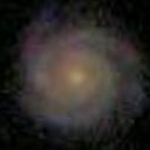

In [ ]:
# resized to allow for easier cropping increments
galaxy_cropped = galaxy.resize((500,500)).crop((175,175,325,325))
galaxy_cropped

In [ ]:
galaxy_cropped.size # check size to potentially resize later

(150, 150)

In [ ]:
# now able to easily crop galaxies en mass
def crop_galaxy(image):
  return image.resize((500,500)).crop((175,175,325,325))

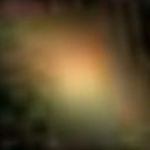

In [ ]:
# check another random galaxy to ensure that cropping is generalizable
crop_galaxy(Image.open("drive/MyDrive/GalaxyClassification/training_images/121413.jpg"))

# Data Preprocessing

In this section, I am pre-processing both the image and table data for my first model and formatting it in a Pandas dataframe, so that the relevant parts of the data will be reusable for later models.

In [ ]:
# removes extention from filename, in this case leaving the image id
def get_id(filename):
  id = os.path.splitext(filename)[0]
  return int(id)

In [ ]:
# Process 527 images into RGB pixel arrays, artificially creating new data
img_list = [] # stores a list of RGB pixel arrays for each image rotation
id_list = [] # stores a list of 8 ids per image for each rotation
for filename in os.listdir(image_path): # images are stored on my Google Drive
  id = get_id(filename) # get id from filename
  single_image_path = os.path.join(image_path, filename)
  image = Image.open(single_image_path)
  image = crop_galaxy(image) # using the function defined in the Test Image section

  for angle in (0,45,90,135,180,225,270,315):
    rotated_image = image.rotate(angle) # create new images through rotation
    img_list.append(img_to_array(rotated_image.resize((50,50)))) # resize a final time to reduce data dimensionality
    id_list.append(id) # save the id for each rotation

In [ ]:
# Process csv, finding those with the same ids as the processed galaxies
label_list = [] # each label will be formatted as [% elliptical, % spiral]
for id in id_list: # for each id, accounting for all rotations
  id_row = solutions.loc[solutions['GalaxyID']==id] # the row with associated ID
  elliptical = np.asarray(id_row['Class1.1'])[0] # % users classified as elliptical
  spiral = np.asarray(id_row['Class1.2'])[0] # % users classified as spiral
  if (elliptical > spiral):
    label_list.append(np.asarray([1, 0]))
  else:
    label_list.append(np.asarray([0, 1]))

In [ ]:
# turn lists into dataframe columns
galaxy_data = pd.DataFrame()
galaxy_data['Image_Array'] = img_list # created 4216 data points from original 527
galaxy_data['Classification'] = label_list
galaxy_data['GalaxyID'] = id_list
galaxy_data

,Image_Array,Classification,GalaxyID
0,"[[[32.0, 33.0, 28.0], [32.0, 33.0, 27.0], [28....","[1, 0]",255855
1,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[1, 0]",255855
2,"[[[2.0, 2.0, 1.0], [1.0, 1.0, 0.0], [1.0, 1.0,...","[1, 0]",255855
3,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[1, 0]",255855
4,"[[[3.0, 3.0, 3.0], [2.0, 2.0, 0.0], [0.0, 0.0,...","[1, 0]",255855
...,...,...,...
4211,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[0, 1]",188497
4212,"[[[20.0, 20.0, 15.0], [17.0, 16.0, 17.0], [14....","[0, 1]",188497
4213,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[0, 1]",188497
4214,"[[[10.0, 13.0, 7.0], [4.0, 3.0, 1.0], [4.0, 0....","[0, 1]",188497


# Model 1- classifying spiral galaxies from elliptical galaxies

In this section, the pre-processed data is split into train and test sets, then the model is compiled and trained with 80% of the above data. Because this process takes over 30 minutes to complete, the model is saved for later evaluation without having to re-fit.

In [ ]:
# split data into train and test sets, with 80% of the data being used to train by convention
x_train, x_test, y_train, y_test = train_test_split(galaxy_data['Image_Array'].to_list(),
                                                    galaxy_data['Classification'].to_list(),
                                                    test_size = .2,
                                                    random_state=42) # 80/20 rule for 20% test set
print("x_train size: \t", len(x_train))
print("x_test size: \t", len(x_test))
x_train[0].shape # checking shape that will be loaded into the model

x_train size: 	 3372
x_test size: 	 844


(50, 50, 3)

In [ ]:
model_1 = keras.Sequential() # a Sequential model means that each step will be completed one after the other

''' First convolutional layer finds high-level features '''
model_1.add(Conv2D(64, (3, 3), input_shape=(50, 50, 3))) # filters (in powers of 2), kernel_size (square 1, 3, 5, or 7)
model_1.add(PReLU()) # Parameterized ReLU- x>0, y=x; x<0, y=ax with a as a learning coefficient
model_1.add(MaxPooling2D()) # find the most prominent features in the image and reduce dimensionality
model_1.add(Dropout(.2)) # combat overfitting by randomly droping 20% of the neurons/features

''' Second convolutional layer fins more fine features '''
model_1.add(Conv2D(128, (3, 3))) # allows the model to find features within the image
model_1.add(PReLU())
model_1.add(MaxPooling2D()) # allows the model to be more lenient on where the the galaxy is positioned in the image
model_1.add(Dropout(.2))
model_1.add(Flatten()) # flatten the output from the convolutional layers to be used in a trasitional neural network

''' Dense layer groups features together that will determine the type of galaxy '''
model_1.add(Dense(512)) # neural network with 512 neurons, each with weights and biases from the previous layer and to the next layer
model_1.add(PReLU()) # PReLU activation function is linear when incoming data is positive, multiplying negative data with a changing constant

''' Final Dense layer provides output as a percentage chance that the galaxy is elliptical/spiral '''
model_1.add(Dense(2, activation='softmax')) # softmax activation allows data to be interpreted as precentages

model_1.summary() # the final model has over 8 million trainable parameters

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 48, 48, 64)        1792      
_________________________________________________________________
p_re_lu_3 (PReLU)            (None, 48, 48, 64)        147456    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 128)       73856     
_________________________________________________________________
p_re_lu_4 (PReLU)            (None, 22, 22, 128)       61952     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 11, 128)      

In [ ]:
# compile and fit the model with the Adam optimizer, which changes the learning rate as appropriate
# I chose to use the Adam optimizer because it is my standard optimizer of choice and adapts the model's learning rate well to not overcorrect
model_1.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=.001), metrics=['accuracy'])
model_1.fit(np.asarray(x_train), np.asarray(y_train), epochs=50, verbose=True) # fit the model with training data over 50 epochs

Epoch 1/50
106/106 [==============================] - 33s 302ms/step - loss: 33.1911 - accuracy: 0.5520
Epoch 2/50
106/106 [==============================] - 32s 301ms/step - loss: 0.6167 - accuracy: 0.6812
Epoch 3/50
106/106 [==============================] - 32s 300ms/step - loss: 0.5685 - accuracy: 0.7167
Epoch 4/50
106/106 [==============================] - 32s 301ms/step - loss: 0.5863 - accuracy: 0.7059
Epoch 5/50
106/106 [==============================] - 32s 303ms/step - loss: 0.5637 - accuracy: 0.7208
Epoch 6/50
106/106 [==============================] - 32s 301ms/step - loss: 0.5529 - accuracy: 0.7333
Epoch 7/50
106/106 [==============================] - 32s 302ms/step - loss: 0.5650 - accuracy: 0.7288
Epoch 8/50
106/106 [==============================] - 32s 303ms/step - loss: 0.5516 - accuracy: 0.7211
Epoch 9/50
106/106 [==============================] - 32s 302ms/step - loss: 0.5328 - accuracy: 0.7528
Epoch 10/50
106/106 [==============================] - 32s 300ms/step - 

Trained model has a accuracy rating of over 95%. This is good for only 50 epochs, as more runs through the model can cause it to overfit to the training data and generalize to new data porrly.

In [ ]:
# save model (takes around 30 minutes to complete with 96% accuracy at last epoch)
model_1.save('drive/MyDrive/GalaxyClassification/Model_1')

INFO:tensorflow:Assets written to: drive/MyDrive/GalaxyClassification/Model_1/assets


# Model 1- evaluate

In this section, I evaluate the first model that classifies galaxies as either elliptical or spiral. Its accuracy score on the test set can help tell how easily the model generalizes to new data, with good generalization being the mark of a good model.

In [ ]:
# load model
saved_model_1 = load_model('drive/MyDrive/GalaxyClassification/Model_1')
saved_model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 48, 48, 64)        1792      
_________________________________________________________________
p_re_lu_3 (PReLU)            (None, 48, 48, 64)        147456    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 128)       73856     
_________________________________________________________________
p_re_lu_4 (PReLU)            (None, 22, 22, 128)       61952     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 11, 128)      

In [ ]:
# evaluate model on train and test sets
train_eval = saved_model_1.evaluate(np.asarray(x_train), np.asarray(y_train), verbose=True)
test_eval = saved_model_1.evaluate(np.asarray(x_test), np.asarray(y_test), verbose=True)
print("Train loss, accuracy: %s, %s" % (train_eval[0], train_eval[1]))
print("Test loss, accuracy: %s, %s" % (test_eval[0], test_eval[1]))

27/27 [==============================] - 2s 74ms/step - loss: 1.3772 - accuracy: 0.7832
Train loss, accuracy: 0.02582663670182228, 0.989916980266571
Test loss, accuracy: 1.377158522605896, 0.7831753492355347


The numbers shown above, with 99% accuracy on the train set and 78.3% training on the test set, show that the model is able to generalize fairly well to differentiate between spiral and elliptical galaxies, considering that a blind guessing model would have an accuracy rating of 50%.

Model_1 Prediction: 0.999999 spiral, 0.000001 elliptical


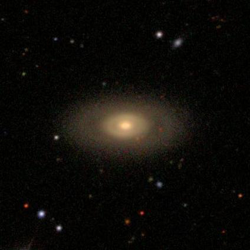

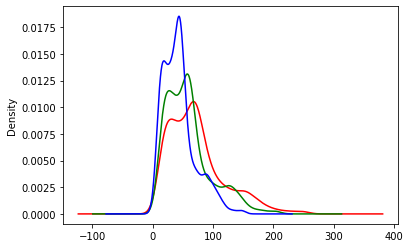

In [ ]:
# evaluate the model visibly, with new data
spiral_image = Image.open('drive/MyDrive/GalaxyClassification/eval_images/names_set/notBarred_2_100186.jpg')
spiral_array = img_to_array(crop_galaxy(spiral_image).resize((50, 50)))
spiral_prediction = saved_model_1.predict(np.expand_dims(spiral_array, axis=0))
print("Model_1 Prediction: " + str(format(spiral_prediction[0][0], "2f")) 
        + " elliptical, " + str(format(spiral_prediction[0][1], "2f")) + " spiral")
for layer, color in enumerate(['r','g','b']):
    pd.Series(spiral_array[:,:,layer].flatten()).plot.density(c=color)

Image.open('drive/MyDrive/GalaxyClassification/eval_images/names_set/notBarred_2_100186.jpg').resize((250,250))

The graph above show the RGB pixel densities for the accompanying image. I chose to plot this graph because spiral galaxies generally have more active star formatin and tend to be bluer than ellipticals, and I wanted to see if the model took color into account. This particular image seems to have more blue in it than red or green, however the actual galaxy itself seems to be a mix of red and green, resulting in a yellow color.

Model_1 Prediction: 0.056651 spiral, 0.943349 elliptical


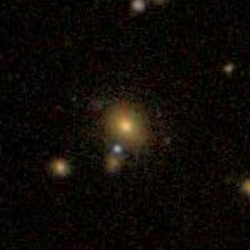

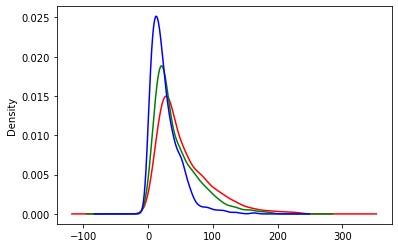

In [ ]:
ell_image = Image.open('drive/MyDrive/GalaxyClassification/eval_images/names_set/midE_2_108692.jpg')
ell_array = img_to_array(crop_galaxy(ell_image).resize((50, 50)))
ell_prediction = saved_model_1.predict(np.expand_dims(ell_array, axis=0))
print("Model_1 Prediction: " + str(format(ell_prediction[0][0], "2f")) 
        + " spiral, " + str(format(ell_prediction[0][1], "2f")) + " elliptical")
for layer, color in enumerate(['r','g','b']):
    pd.Series(ell_array[:,:,layer].flatten()).plot.density(c=color)

Image.open('drive/MyDrive/GalaxyClassification/eval_images/names_set/midE_2_108692.jpg').resize((250,250))
# smallE_5_170648, midE_3_113516

# Data preprocessing for barred spirals and ellipticities

This section does additional preprocessing of the original table to get whether a spiral galaxy is edge on (whether it is barred cannot be determined), not barred, or barred, and whather an elliptical galaxy is in the range E0-E1, E2-E5, or E6-E7. I chose these ranges because users are likely to be biased towards choosing "in between" rather than "round" or "cigar-shaped."

In [ ]:
# define new columns as the esixsting column holding a list so they are primed to hold our new classifications
galaxy_data['Ellipticity'] = galaxy_data['Classification']
galaxy_data['EdgeOn_Not_or_Bar'] = galaxy_data['Classification']

# add more specific classifications based on the original
# formatted as [% E0-1, % E2-5, % E6-7]
for index in range(len(galaxy_data)): # go through each row in the dataframe
  id_row = solutions.loc[solutions['GalaxyID']==galaxy_data['GalaxyID'][index]]
  elliptical = galaxy_data['Classification'][index][0]
  spiral = galaxy_data['Classification'][index][1]
  # determine ellipticity if elliptical
  if (elliptical > spiral):
    galaxy_data.at[index, 'EdgeOn_Not_or_Bar'] = np.nan # do not classify spiral features

    # ellipticity is based on Task 7 / Task 1 for elliptical choice
    # due to original table values being multiplied by the choice leading to it
    e0_e1 = np.asarray(id_row['Class7.1'])[0] / np.asarray(id_row['Class1.1'])[0]
    e2_e3_e4_e5 = np.asarray(id_row['Class7.2'])[0] / np.asarray(id_row['Class1.1'])[0]
    e6_e7 = np.asarray(id_row['Class7.3'])[0] / np.asarray(id_row['Class1.1'])[0]

    # very round, likely E0 or E1
    if ((e0_e1 > e2_e3_e4_e5) and (e0_e1 > e6_e7)):
      galaxy_data.at[index, 'Ellipticity'] = np.asarray([1, 0, 0])

    # in-between, likely E2-E5
    elif ((e2_e3_e4_e5 > e0_e1) and (e2_e3_e4_e5 > e6_e7)):
      galaxy_data.at[index, 'Ellipticity'] = np.asarray([0, 1, 0])

    # cigar-shaped, likely E6 or E7
    else:
      galaxy_data.at[index, 'Ellipticity'] = np.asarray([0, 0, 1])
  # otherwise, based on what we can classify with our data, we say the galaxy is spiral
  else:
    galaxy_data.at[index, 'Ellipticity'] = np.nan # do not classify ellipticity

    # edge on Task is Task 2; if edge on, whether the galaxy is barred won't be possible to classify
    # based on edge on Task 2 / Task 1 decision on if it's spiral
    edge_on = np.asarray(id_row['Class2.1'])[0] / np.asarray(id_row['Class1.2'])[0]
    if (edge_on > (np.asarray(id_row['Class2.2'])[0] / np.asarray(id_row['Class1.2'])[0])):
      galaxy_data.at[index, 'EdgeOn_Not_or_Bar'] = np.asarray([1, 0, 0])

    # not edge on, so classify whether it is barred based on Task 3 / Task 2 (not edge on)
    else:
      bar = np.asarray(id_row['Class3.1'])[0] / (np.asarray(id_row['Class2.2'])[0] + .00001)

      # barred
      if (bar > (np.asarray(id_row['Class3.2'])[0] / (np.asarray(id_row['Class2.2'])[0] + .00001))):
        galaxy_data.at[index, 'EdgeOn_Not_or_Bar'] = np.asarray([0, 0, 1])

      # not barred
      else:
        galaxy_data.at[index, 'EdgeOn_Not_or_Bar'] = np.asarray([0, 1, 0])

galaxy_data # preview the amended dataframe

,Image_Array,Classification,GalaxyID,Ellipticity,EdgeOn_Not_or_Spiral
0,"[[[32.0, 33.0, 28.0], [32.0, 33.0, 27.0], [28....","[1, 0]",255855,"[1, 0, 0]",NaN
1,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[1, 0]",255855,"[1, 0, 0]",NaN
2,"[[[2.0, 2.0, 1.0], [1.0, 1.0, 0.0], [1.0, 1.0,...","[1, 0]",255855,"[1, 0, 0]",NaN
3,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[1, 0]",255855,"[1, 0, 0]",NaN
4,"[[[3.0, 3.0, 3.0], [2.0, 2.0, 0.0], [0.0, 0.0,...","[1, 0]",255855,"[1, 0, 0]",NaN
...,...,...,...,...,...
4211,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[0, 1]",188497,NaN,"[0, 1, 0]"
4212,"[[[20.0, 20.0, 15.0], [17.0, 16.0, 17.0], [14....","[0, 1]",188497,NaN,"[0, 1, 0]"
4213,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[0, 1]",188497,NaN,"[0, 1, 0]"
4214,"[[[10.0, 13.0, 7.0], [4.0, 3.0, 1.0], [4.0, 0....","[0, 1]",188497,NaN,"[0, 1, 0]"


In [ ]:
# split data into elliptical galaxies for Model 3, spiral for Model 2
mask = galaxy_data['Ellipticity'].isnull()
spiral_data = galaxy_data[mask]
elliptical_data = galaxy_data[~mask]
spiral_data

,Image_Array,Classification,GalaxyID,Ellipticity,EdgeOn_Not_or_Spiral
8,"[[[12.0, 12.0, 10.0], [13.0, 13.0, 11.0], [5.0...","[0, 1]",238878,NaN,"[0, 1, 0]"
9,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[0, 1]",238878,NaN,"[0, 1, 0]"
10,"[[[3.0, 3.0, 3.0], [1.0, 1.0, 1.0], [1.0, 1.0,...","[0, 1]",238878,NaN,"[0, 1, 0]"
11,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[0, 1]",238878,NaN,"[0, 1, 0]"
12,"[[[0.0, 6.0, 8.0], [1.0, 7.0, 6.0], [2.0, 8.0,...","[0, 1]",238878,NaN,"[0, 1, 0]"
...,...,...,...,...,...
4211,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[0, 1]",188497,NaN,"[0, 1, 0]"
4212,"[[[20.0, 20.0, 15.0], [17.0, 16.0, 17.0], [14....","[0, 1]",188497,NaN,"[0, 1, 0]"
4213,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[0, 1]",188497,NaN,"[0, 1, 0]"
4214,"[[[10.0, 13.0, 7.0], [4.0, 3.0, 1.0], [4.0, 0....","[0, 1]",188497,NaN,"[0, 1, 0]"


# Model 2- classifying edge on spirals (unable to tell if barred), non-barred spirals, and barred spirals

This section splits the data into train and test sets, then trains a new model to classify whether spiral galaxies are barred.

In [ ]:
# 20% of data going into test set
x_bar_train, x_bar_test, y_bar_train, y_bar_test = train_test_split(spiral_data['Image_Array'].to_list(),
                                                                    spiral_data['EdgeOn_Not_or_Bar'].to_list(),
                                                                    test_size = .2,
                                                                    random_state = 42)
print("x_bar_train size: \t", len(x_bar_train))
print("x_bar_test size: \t", len(x_bar_test))

x_train size: 	 1772
x_test size: 	 444


In [ ]:
# very similar model to Model 1
model_bar = keras.Sequential()
model_bar.add(Conv2D(64, (3, 3), input_shape=(50, 50, 3))) # filters (in powers of 2), kernel_size (square 1, 3, 5, or 7)
model_bar.add(PReLU()) # Parameterized ReLU- x>0, y=x; x<0, y=ax with a as a learning coefficient
model_bar.add(MaxPooling2D()) # find the most prominent features in the image and reduce dimensionality
model_bar.add(Dropout(.2)) # combat overfitting by randomly droping 20% of the neurons/features

model_bar.add(Conv2D(128, (3, 3))) # allows the model to find features within the image
model_bar.add(PReLU())
model_bar.add(MaxPooling2D()) # allows the model to be more lenient on where the the galaxy is positioned in the image
model_bar.add(Dropout(.2)) #''' read paper https://jmlr.org/papers/v15/srivastava14a.html on dropout '''
model_bar.add(Flatten())

model_bar.add(Dense(512))
model_bar.add(PReLU())

model_bar.add(Dense(3, activation='softmax'))

model_bar.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 48, 48, 64)        1792      
_________________________________________________________________
p_re_lu_3 (PReLU)            (None, 48, 48, 64)        147456    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 128)       73856     
_________________________________________________________________
p_re_lu_4 (PReLU)            (None, 22, 22, 128)       61952     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 11, 128)      

In [ ]:
# compile and fit model with same parameters as Model 1
model_bar.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=.001), metrics=['accuracy'])
model_bar.fit(np.asarray(x_bar_train), np.asarray(y_bar_train), epochs=50, verbose=True)

Epoch 1/50
56/56 [==============================] - 22s 372ms/step - loss: 15.9180 - accuracy: 0.6101
Epoch 2/50
56/56 [==============================] - 21s 368ms/step - loss: 0.5342 - accuracy: 0.6308
Epoch 3/50
56/56 [==============================] - 21s 366ms/step - loss: 0.4913 - accuracy: 0.6745
Epoch 4/50
56/56 [==============================] - 21s 376ms/step - loss: 0.4601 - accuracy: 0.6923
Epoch 5/50
56/56 [==============================] - 21s 379ms/step - loss: 0.4408 - accuracy: 0.7066
Epoch 6/50
56/56 [==============================] - 21s 367ms/step - loss: 0.4241 - accuracy: 0.7260
Epoch 7/50
56/56 [==============================] - 21s 372ms/step - loss: 0.4262 - accuracy: 0.7088
Epoch 8/50
56/56 [==============================] - 21s 372ms/step - loss: 0.4171 - accuracy: 0.7113
Epoch 9/50
56/56 [==============================] - 21s 373ms/step - loss: 0.4306 - accuracy: 0.7151
Epoch 10/50
56/56 [==============================] - 21s 372ms/step - loss: 0.3782 - accur

98.8% accuracy over 50 epochs for 1700 training images

In [ ]:
# save model (takes around 30 minutes to complete with 99% accuracy at last epoch)
model_bar.save('drive/MyDrive/GalaxyClassification/Model_Bar')

INFO:tensorflow:Assets written to: drive/MyDrive/GalaxyClassification/Model_Bar/assets


# Model 2- evaluate

This section evaluates Model 2, which classifies whether a spiral galaxy is edge on, not barred, or barred.

In [ ]:
# load model
saved_model_bar = load_model('drive/MyDrive/GalaxyClassification/Model_Bar')
saved_model_bar.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 48, 48, 64)        1792      
_________________________________________________________________
p_re_lu_3 (PReLU)            (None, 48, 48, 64)        147456    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 128)       73856     
_________________________________________________________________
p_re_lu_4 (PReLU)            (None, 22, 22, 128)       61952     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 11, 128)      

In [ ]:
# evaluate model on train and test sets
train_eval_bar = saved_model_bar.evaluate(np.asarray(x_bar_train), np.asarray(y_bar_train), verbose=True)
test_eval_bar = saved_model_bar.evaluate(np.asarray(x_bar_test), np.asarray(y_bar_test), verbose=True)
print("Train loss, accuracy: %s, %s" % (train_eval_bar[0], train_eval_bar[1]))
print("Test loss, accuracy: %s, %s" % (test_eval_bar[0], test_eval_bar[1]))

14/14 [==============================] - 1s 102ms/step - loss: 0.9028 - accuracy: 0.7680
Train loss, accuracy: 0.007753140293061733, 0.9983069896697998
Test loss, accuracy: 0.9027715921401978, 0.7680180072784424


76.8% accuracy on the test set is great, especially considering that a guessing model would only get 33% accuracy.

In [ ]:
# quick function to predict and graph RGB pixel desities based on an image
def single_image_eval_bar(image_path):
  sieb_image = Image.open(image_path)
  sieb_array = img_to_array(crop_galaxy(sieb_image).resize((50, 50)))
  sieb_prediction = saved_model_bar.predict(np.expand_dims(sieb_array, axis=0))
  print("Model_1 Prediction: " + str(format(sieb_prediction[0][0], "2f")) 
         + " edge on, " + str(format(sieb_prediction[0][1], "2f")) + " not barred, "
         + str(format(sieb_prediction[0][2], "2f")) + " barred")
  for layer, color in enumerate(['r','g','b']):
      pd.Series(sieb_array[:,:,layer].flatten()).plot.density(c=color)

Model_1 Prediction: 0.000000 edge on, 0.000000 not barred, 1.000000 barred


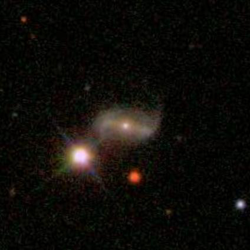

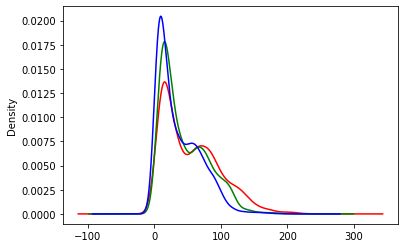

In [ ]:
# barred spiral
single_image_eval_bar('drive/MyDrive/GalaxyClassification/eval_images/names_set/barred_2_171436.jpg')

Image.open('drive/MyDrive/GalaxyClassification/eval_images/names_set/barred_2_171436.jpg').resize((250,250))

Model_1 Prediction: 0.000000 edge on, 1.000000 not barred, 0.000000 barred


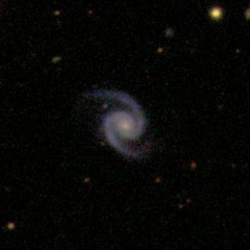

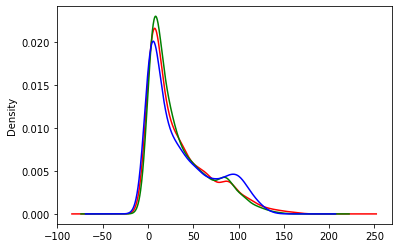

In [ ]:
# not barred spiral
single_image_eval_bar('drive/MyDrive/GalaxyClassification/eval_images/names_set/notBarred_1_182971.jpg')

Image.open('drive/MyDrive/GalaxyClassification/eval_images/names_set/notBarred_1_182971.jpg').resize((250,250))

Model_1 Prediction: 1.000000 edge on, 0.000000 not barred, 0.000000 barred


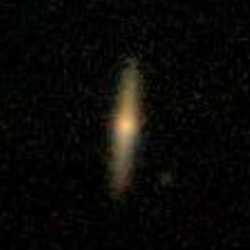

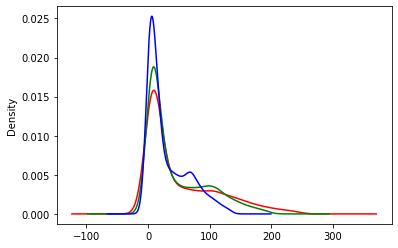

In [ ]:
# edge on spiral
single_image_eval_bar('drive/MyDrive/GalaxyClassification/eval_images/names_set/edgeOn_1_107946.jpg')

Image.open('drive/MyDrive/GalaxyClassification/eval_images/names_set/edgeOn_1_107946.jpg').resize((250,250))

# Model 3- classifying galaxies based on ellipticity (E0-1, E2-5, E6-7)

This section splits the elliptical data, and trains Model 3 to classify whether a galaxy is more round, cigar-shaped, or in-between.

In [ ]:
# 20% of data goes to test set to evaluate model generalizability
x_ell_train, x_ell_test, y_ell_train, y_ell_test = train_test_split(elliptical_data['Image_Array'].to_list(),
                                                                    elliptical_data['Ellipticity'].to_list(),
                                                                    test_size = .2,
                                                                    random_state = 42)
print("x_ell_train size: \t", len(x_ell_train))
print("x_ell_test size: \t", len(x_ell_test))

x_ell_train size: 	 1600
x_ell_test size: 	 400


In [ ]:
# Model is similar to Models 1 and 2
model_ell = keras.Sequential()
model_ell.add(Conv2D(64, (3, 3), input_shape=(50, 50, 3))) # filters (in powers of 2), kernel_size (square 1, 3, 5, or 7)
model_ell.add(PReLU()) # Parameterized ReLU- x>0, y=x; x<0, y=ax with a as a learning coefficient
model_ell.add(MaxPooling2D()) # find the most prominent features in the image and reduce dimensionality
model_ell.add(Dropout(.2)) # combat overfitting by randomly droping 20% of the neurons/features

model_ell.add(Conv2D(128, (3, 3))) # allows the model to find features within the image
model_ell.add(PReLU())
model_ell.add(MaxPooling2D()) # allows the model to be more lenient on where the the galaxy is positioned in the image
model_ell.add(Dropout(.2)) #''' read paper https://jmlr.org/papers/v15/srivastava14a.html on dropout '''
model_ell.add(Flatten())

model_ell.add(Dense(512))
model_ell.add(PReLU())

model_ell.add(Dense(3, activation='softmax'))

model_ell.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 48, 48, 64)        1792      
_________________________________________________________________
p_re_lu_6 (PReLU)            (None, 48, 48, 64)        147456    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 22, 22, 128)       73856     
_________________________________________________________________
p_re_lu_7 (PReLU)            (None, 22, 22, 128)       61952     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 11, 11, 128)      

In [ ]:
# compile and train model with same parameters as Models 1 and 2
model_ell.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=.001), metrics=['accuracy'])
model_ell.fit(np.asarray(x_ell_train), np.asarray(y_ell_train), epochs=50, verbose=True)

Epoch 1/50
50/50 [==============================] - 19s 365ms/step - loss: 21.7935 - accuracy: 0.4675
Epoch 2/50
50/50 [==============================] - 18s 369ms/step - loss: 0.5662 - accuracy: 0.4821
Epoch 3/50
50/50 [==============================] - 18s 368ms/step - loss: 0.5539 - accuracy: 0.5099
Epoch 4/50
50/50 [==============================] - 18s 366ms/step - loss: 0.5523 - accuracy: 0.4993
Epoch 5/50
50/50 [==============================] - 18s 365ms/step - loss: 0.5311 - accuracy: 0.5413
Epoch 6/50
50/50 [==============================] - 18s 366ms/step - loss: 0.4938 - accuracy: 0.6263
Epoch 7/50
50/50 [==============================] - 18s 366ms/step - loss: 0.4519 - accuracy: 0.6776
Epoch 8/50
50/50 [==============================] - 18s 366ms/step - loss: 0.4651 - accuracy: 0.6774
Epoch 9/50
50/50 [==============================] - 18s 366ms/step - loss: 0.3915 - accuracy: 0.7302
Epoch 10/50
50/50 [==============================] - 19s 370ms/step - loss: 0.3709 - accur

96.5% accuracy over 50 epochs

In [ ]:
# save model (takes around 30 minutes to complete with 97% accuracy at last epoch)
model_ell.save('drive/MyDrive/GalaxyClassification/Model_Ell')

INFO:tensorflow:Assets written to: drive/MyDrive/GalaxyClassification/Model_Ell/assets


# Model 3- evaluate

This section evaluates Model 3, which classifies elliptical galaxies based on their percieved ellipticity

In [ ]:
# load model
saved_model_ell = load_model('drive/MyDrive/GalaxyClassification/Model_Ell')
saved_model_ell.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 48, 48, 64)        1792      
_________________________________________________________________
p_re_lu_6 (PReLU)            (None, 48, 48, 64)        147456    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 22, 22, 128)       73856     
_________________________________________________________________
p_re_lu_7 (PReLU)            (None, 22, 22, 128)       61952     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 11, 11, 128)      

In [ ]:
# evaluate model on train and test sets
train_eval_ell = saved_model_ell.evaluate(np.asarray(x_ell_train), np.asarray(y_ell_train), verbose=True)
test_eval_ell = saved_model_ell.evaluate(np.asarray(x_ell_test), np.asarray(y_ell_test), verbose=True)
print("Train loss, accuracy: %s, %s" % (train_eval_ell[0], train_eval_ell[1]))
print("Test loss, accuracy: %s, %s" % (test_eval_ell[0], test_eval_ell[1]))

13/13 [==============================] - 1s 96ms/step - loss: 0.7046 - accuracy: 0.7875
Train loss, accuracy: 0.04208668693900108, 0.9806249737739563
Test loss, accuracy: 0.7046178579330444, 0.7875000238418579


78.8% accuracy on the test set shows that the model generalizes well, which for me is especially impressive because of the uncertainty in how users would classify mid-range ellipticals.

In [ ]:
# similar to definition in Model 2, only difference being the model used to classify
def single_image_eval_ell(image_path):
  siee_image = Image.open(image_path)
  siee_array = img_to_array(crop_galaxy(siee_image).resize((50, 50)))
  siee_prediction = saved_model_ell.predict(np.expand_dims(siee_array, axis=0))
  print("Model_1 Prediction: " + str(format(siee_prediction[0][0], "2f")) 
         + " E0 or E1, " + str(format(siee_prediction[0][1], "2f")) + " E2 to E5, "
         + str(format(siee_prediction[0][2], "2f")) + " E6 or E7")
  for layer, color in enumerate(['r','g','b']):
      pd.Series(siee_array[:,:,layer].flatten()).plot.density(c=color)

Model_1 Prediction: 0.999858 E0 or E1, 0.000142 E2 to E5, 0.000000 E6 or E7


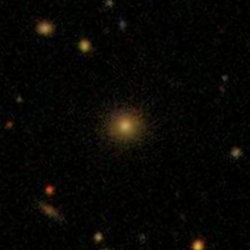

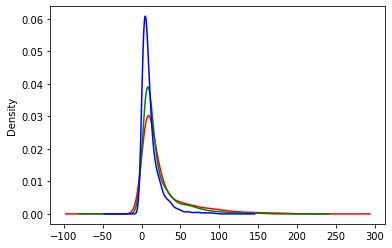

In [ ]:
# small E
single_image_eval_ell('drive/MyDrive/GalaxyClassification/eval_images/names_set/smallE_1_114457.jpg')

Image.open('drive/MyDrive/GalaxyClassification/eval_images/names_set/smallE_1_114457.jpg').resize((250,250))

Model_1 Prediction: 0.320819 E0 or E1, 0.679180 E2 to E5, 0.000001 E6 or E7


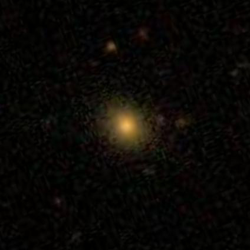

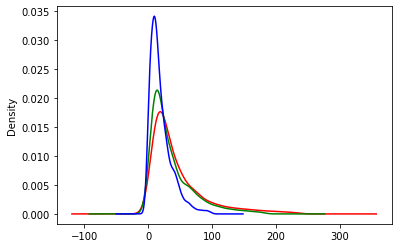

In [ ]:
# mid E
single_image_eval_ell('drive/MyDrive/GalaxyClassification/eval_images/names_set/midE_1_175254.jpg')

Image.open('drive/MyDrive/GalaxyClassification/eval_images/names_set/midE_1_175254.jpg').resize((250,250))

Model_1 Prediction: 0.000000 E0 or E1, 0.000000 E2 to E5, 1.000000 E6 or E7


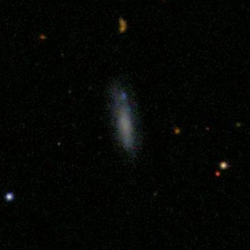

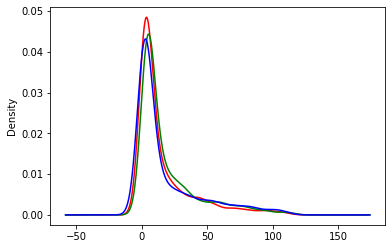

In [ ]:
# large E
single_image_eval_ell('drive/MyDrive/GalaxyClassification/eval_images/names_set/largeE_2_100740.jpg')

Image.open('drive/MyDrive/GalaxyClassification/eval_images/names_set/largeE_2_100740.jpg').resize((250,250))